In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import trimesh
# import plotly.express as px
# import plotly.graph_objects as go
import os,glob,sys
# from plotly.subplots import make_subplots
from pprint import pprint
import scvi
import anndata
import scanpy as sc

intersted_genes = ['Trhr','Pdyn','Tacr3','Shox2','Gpr101',]
markergenes = ['Dbh', 'Th', 'Slc6a2']

In [2]:
# where the original data is saved
homedir = '/allen/aind/scratch/shuonan.chen/pons_images/'
reg_file_path = '/allen/aind/scratch/shuonan.chen/code/pons_merfish_pipeline/processing/registered/'
slicename_all = [os.path.basename(f).split('.')[0].split('registered_')[1] for f in glob.glob(reg_file_path+'*')]
slicename_all.sort()
len(slicename_all)

24

In [3]:

sys.path.append('/home/shuonan.chen/scratch_shuonan/code/pons_merfish_pipeline/processing/func/')
from prepare_img_utils import *
from utils import get_paths
paths = get_paths()
print(paths.keys())

dict_keys(['code_root', 'data_root', 'package_root'])


In [4]:
df = pd.read_csv("/home/shuonan.chen/scratch_shuonan/scripts/Pons_MERFISH/results_to_share/dbh_pos_cells_all_OLD.csv", sep='\t', dtype={0: str})
# this is the stringent criterions 


# run clustering


In [5]:
import anndata as ad
ccf_columns = [col for col in df.columns if "CCF" in col]  # CCF columns
obs_columns = ["neuron_id", "slicename"] + ccf_columns  # Include slicename in obs

columns_to_exclude = [col for col in df.columns if "Blank" in col] + ccf_columns + ["slicename"]

df_filtered = df.drop(columns=columns_to_exclude)
df_filtered.set_index("neuron_id", inplace=True)

adata_mer = ad.AnnData(df_filtered)
adata_mer.obs = df[obs_columns].set_index("neuron_id")


In [6]:
# section_identifier = []
# for k,v in reg_points_all.items():
#     section_identifier.extend([k]*len(v))
    
allmousenames = ['MouseC','MouseF','MouseEg','MouseZM']
section_identifier_highlevel = [next(mouse for mouse in allmousenames if mouse in name)
                                for name in adata_mer.obs.slicename]    

In [7]:
np.unique(np.array(section_identifier_highlevel))

array(['MouseC', 'MouseEg', 'MouseF', 'MouseZM'], dtype='<U7')

In [8]:
adata_mer.obsm["spatial"] = adata_mer.obs[['x_CCF','y_CCF','z_CCF']].values
adata_mer.raw = adata_mer
adata_mer.obs['mouse_name'] = section_identifier_highlevel
adata_mer.obs["slicename"] = adata_mer.obs["slicename"].astype("category")


In [9]:
markergenesid = np.array([np.where(adata_mer.var_names==m)[0][0] for m in markergenes])
totalexpression = np.prod(adata_mer.X[:,markergenesid], 1)
keptcellID = totalexpression>0  # Boolean to indicaet if all three marker genes have to be expre
adata_mer = adata_mer[keptcellID]

In [10]:
totalexpression.shape

(5473,)

# check correlation on pairwise marker genes

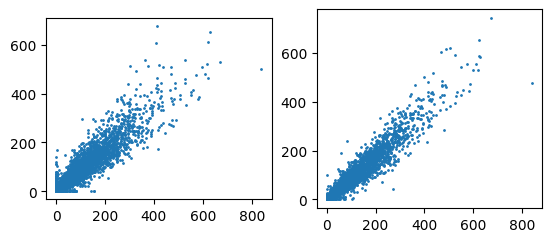

In [11]:
plt.subplot(1,2,1)
plt.scatter(np.array(adata_mer.raw.X[:,adata_mer.var_names=='Dbh'][:,0]),
            np.array(adata_mer.raw.X[:,adata_mer.var_names=='Th'][:,0]), 
           s=1)
plt.gca().set_aspect('equal')

plt.subplot(1,2,2)
plt.scatter(np.array(adata_mer.raw.X[:,adata_mer.var_names=='Dbh'][:,0]),
            np.array(adata_mer.raw.X[:,adata_mer.var_names=='Slc6a2'][:,0]), 
           s=1)
plt.gca().set_aspect('equal')

# scvi

In [23]:
scvi.settings.seed = 1
scvi.model.SCVI.setup_anndata(adata_mer, batch_key="slicename")
model = scvi.model.SCVI(adata_mer, n_hidden=128, n_layers=2, n_latent=10)
model.train(max_epochs=200)
adata_mer.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata_mer, use_rep="X_scVI")
sc.tl.umap(adata_mer, random_state=210)
sc.tl.leiden(adata_mer, resolution=1, random_state=211) 


[rank: 0] Seed set to 1
/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /allen/aind/scratch/shuonan.chen/conda_envs/torch_on ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /allen/aind/scratch/shuonan.chen/conda_envs/torch_on ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_p

Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


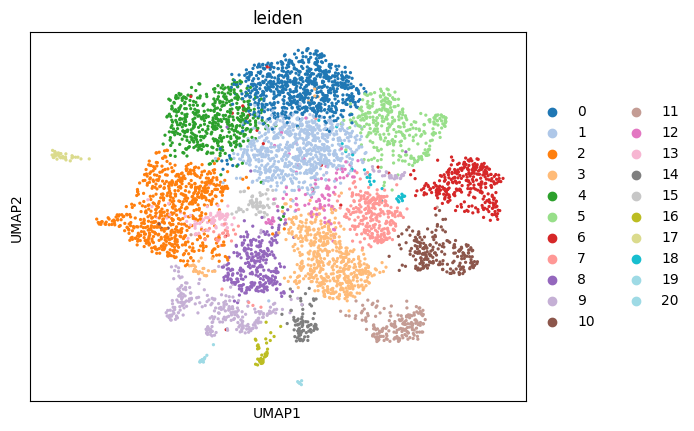

In [24]:
sc.pl.umap(
    adata_mer,
    color="leiden",
    ncols=3,palette="tab20",
)

In [29]:
adata_mer.X.max()

np.float64(13.371845266040449)

In [28]:
sc.pp.normalize_per_cell(adata_mer, counts_per_cell_after=1e6)
sc.pp.log1p(adata_mer)
# sc.pp.pca(adata_mer, n_comps=15)

# check the distribution with teh LC masks 

In [30]:
import trimesh
# mesh = trimesh.load_mesh("/home/shuonan.chen/scripts/Pons_MERFISH/mesh/Segmentation_sm_6pix_dil_both_sides_aligned_with_ccf_index 1.obj")
mesh_LC = trimesh.load_mesh("/allen/aind/scratch/shuonan.chen/scripts/Pons_MERFISH/mesh/LC_ccf_v1_250102 2.obj")
mesh_CD = trimesh.load_mesh("/allen/aind/scratch/shuonan.chen/scripts/Pons_MERFISH/mesh/subCD_ccf_v1_250102 2.obj")
mesh_CV = trimesh.load_mesh("/allen/aind/scratch/shuonan.chen/scripts/Pons_MERFISH/mesh/subCV_ccf_v1_250102 2.obj")
allmeshes = [mesh_LC,mesh_CD,mesh_CV]

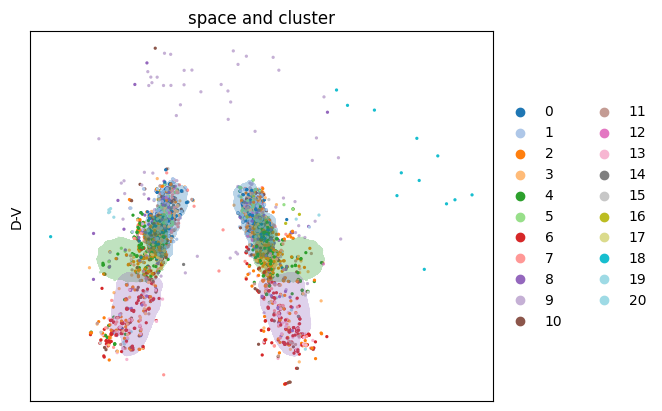

In [31]:
ax = sc.pl.embedding(adata_mer, dimensions = (2, 1),basis="spatial", color="leiden",palette="tab20",
                     title='space and cluster', show=False,return_fig=True)
ax.gca().invert_yaxis()
ax.gca().set_aspect('equal')
ax.gca().triplot(mesh_LC.vertices.T[2], mesh_LC.vertices.T[1], mesh_LC.faces, alpha = .3, label = 'LC')
ax.gca().triplot(mesh_CD.vertices.T[2], mesh_CD.vertices.T[1], mesh_CD.faces, alpha = .3, label = 'CD')
ax.gca().triplot(mesh_CV.vertices.T[2], mesh_CV.vertices.T[1], mesh_CV.faces, alpha = .3, label = 'CV')
ax.gca().set_ylabel('D-V')
ax.gca().set_xlabel('')
ax.savefig('./spoace_cluster.png', dpi=200)

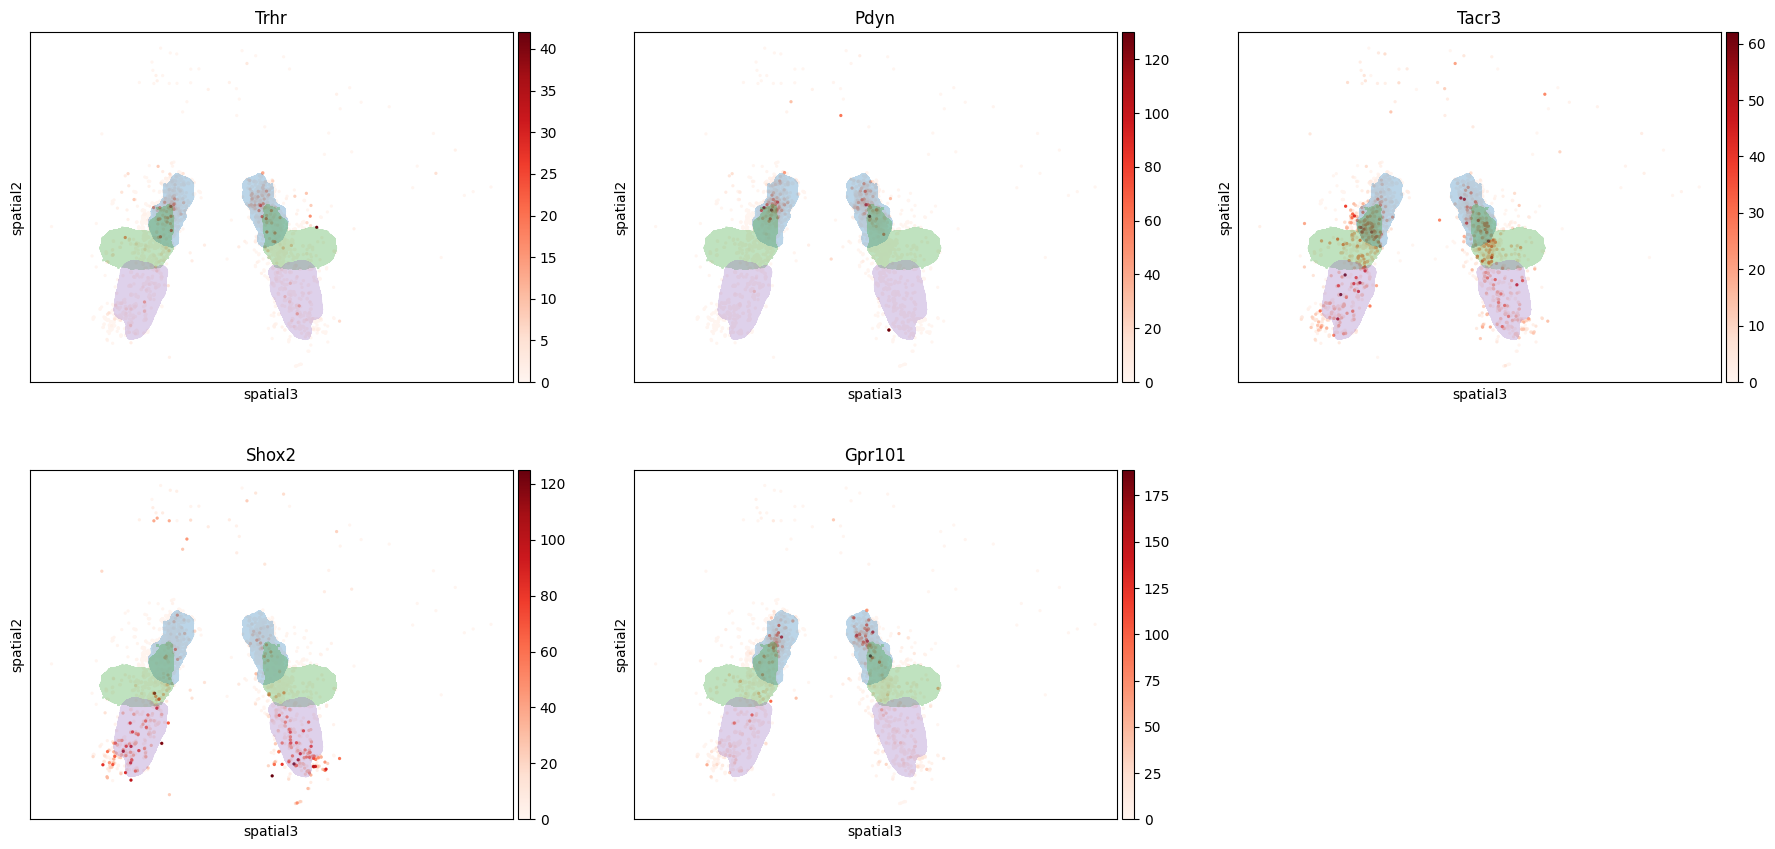

In [32]:
ax = sc.pl.embedding(adata_mer, dimensions = (2, 1),basis="spatial", cmap ='Reds',
                     color=intersted_genes,ncols =3, show=False)

for a in ax:
    a.triplot(mesh_LC.vertices.T[2], mesh_LC.vertices.T[1], mesh_LC.faces, alpha = .3, label = 'LC')
    a.triplot(mesh_CD.vertices.T[2], mesh_CD.vertices.T[1], mesh_CD.faces, alpha = .3, label = 'CD')
    a.triplot(mesh_CV.vertices.T[2], mesh_CV.vertices.T[1], mesh_CV.faces, alpha = .3, label = 'CV')
    a.invert_yaxis()

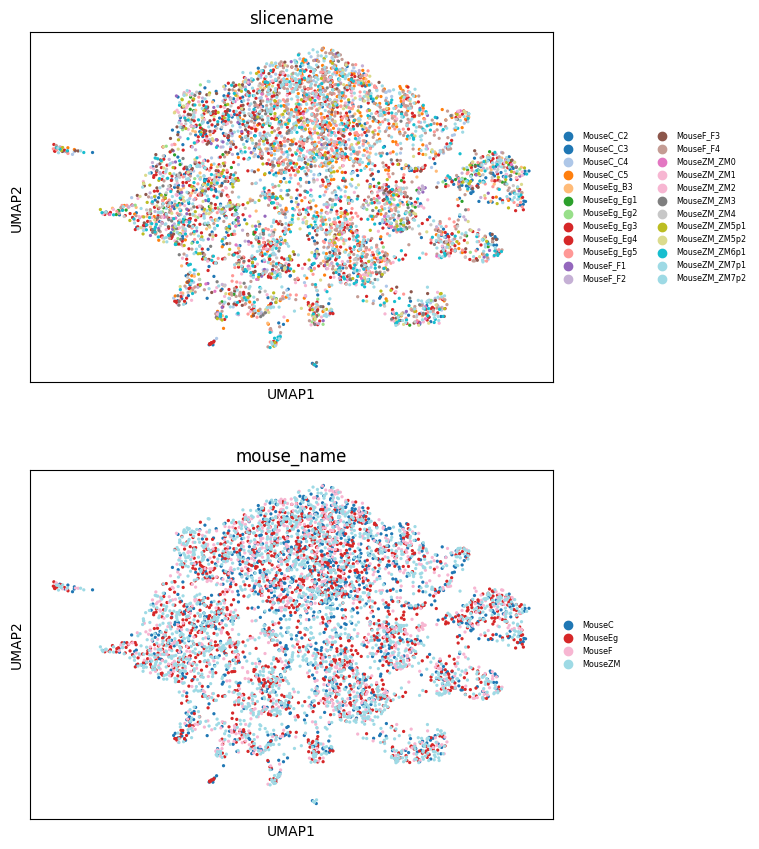

In [33]:
sc.pl.umap(adata_mer, color=['slicename','mouse_name'],
           legend_fontsize='xx-small',
           palette="tab20", cmap = 'Reds', ncols=1)

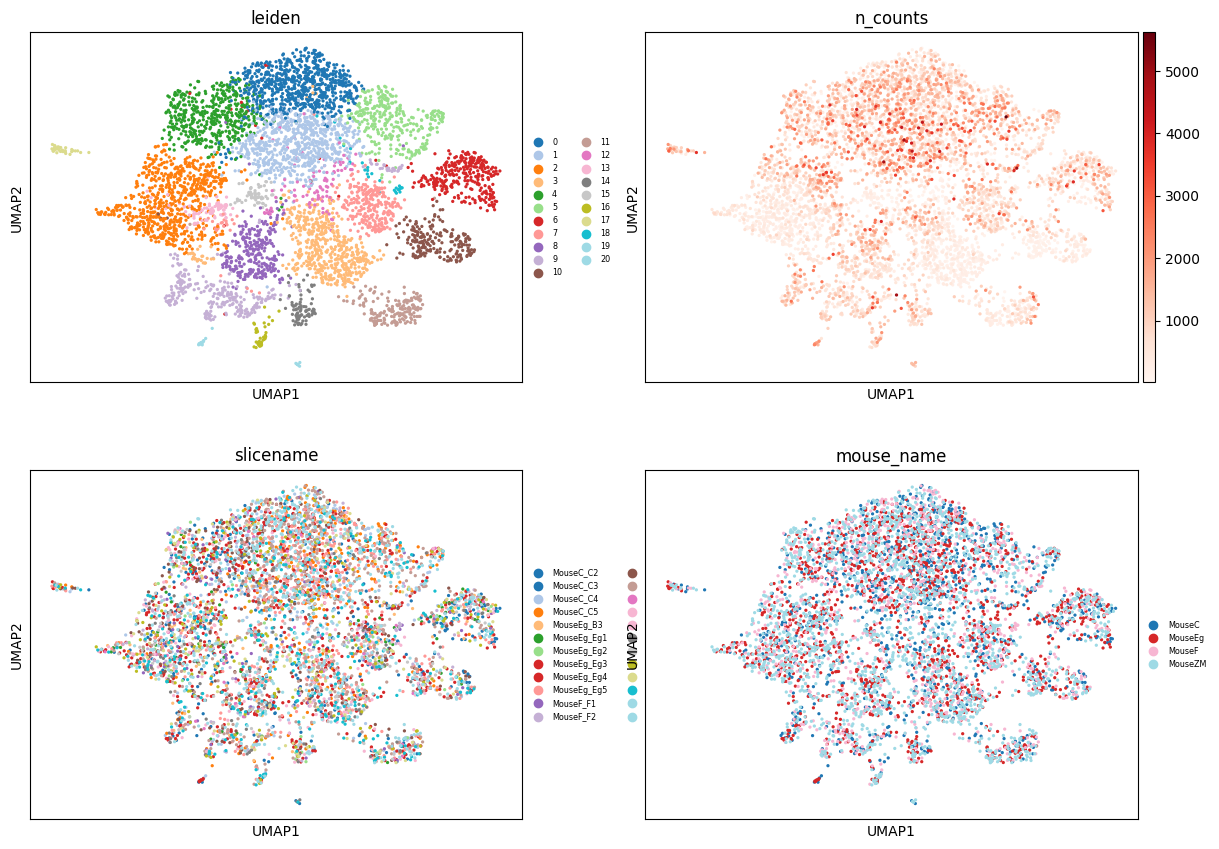

In [34]:
sc.pl.umap(adata_mer, color=["leiden", 'n_counts','slicename','mouse_name'],
           legend_fontsize='xx-small',
           palette="tab20", cmap = 'Reds', ncols=2)

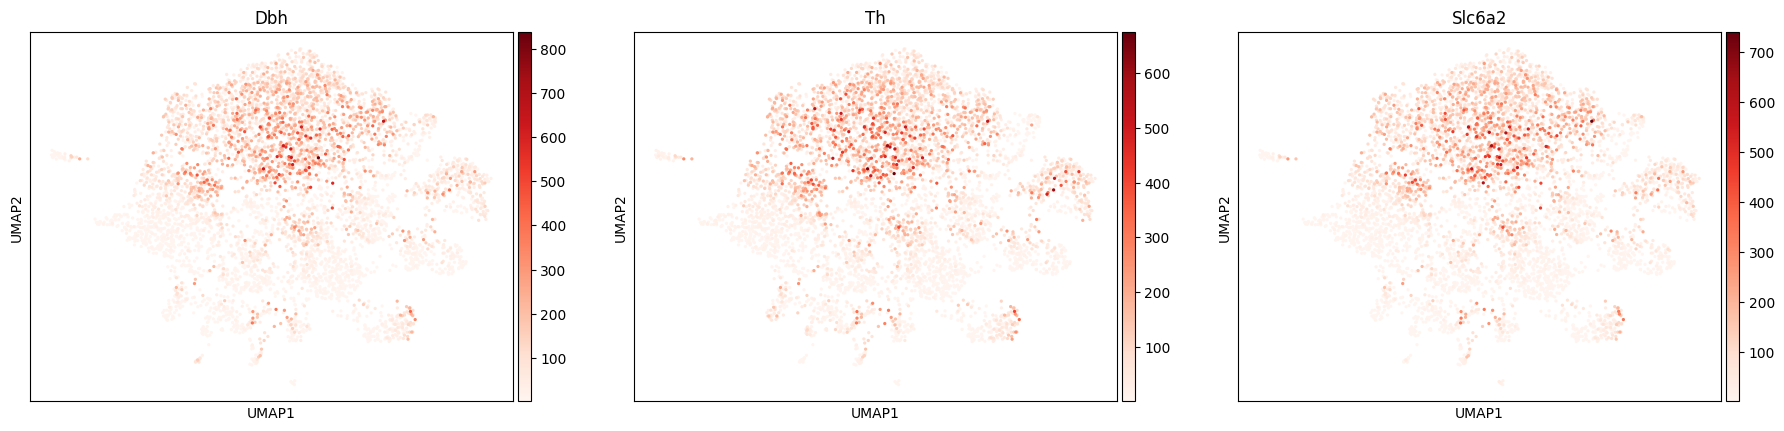

In [35]:
sc.pl.umap(adata_mer, color=['Dbh','Th',"Slc6a2"], cmap = 'Reds')


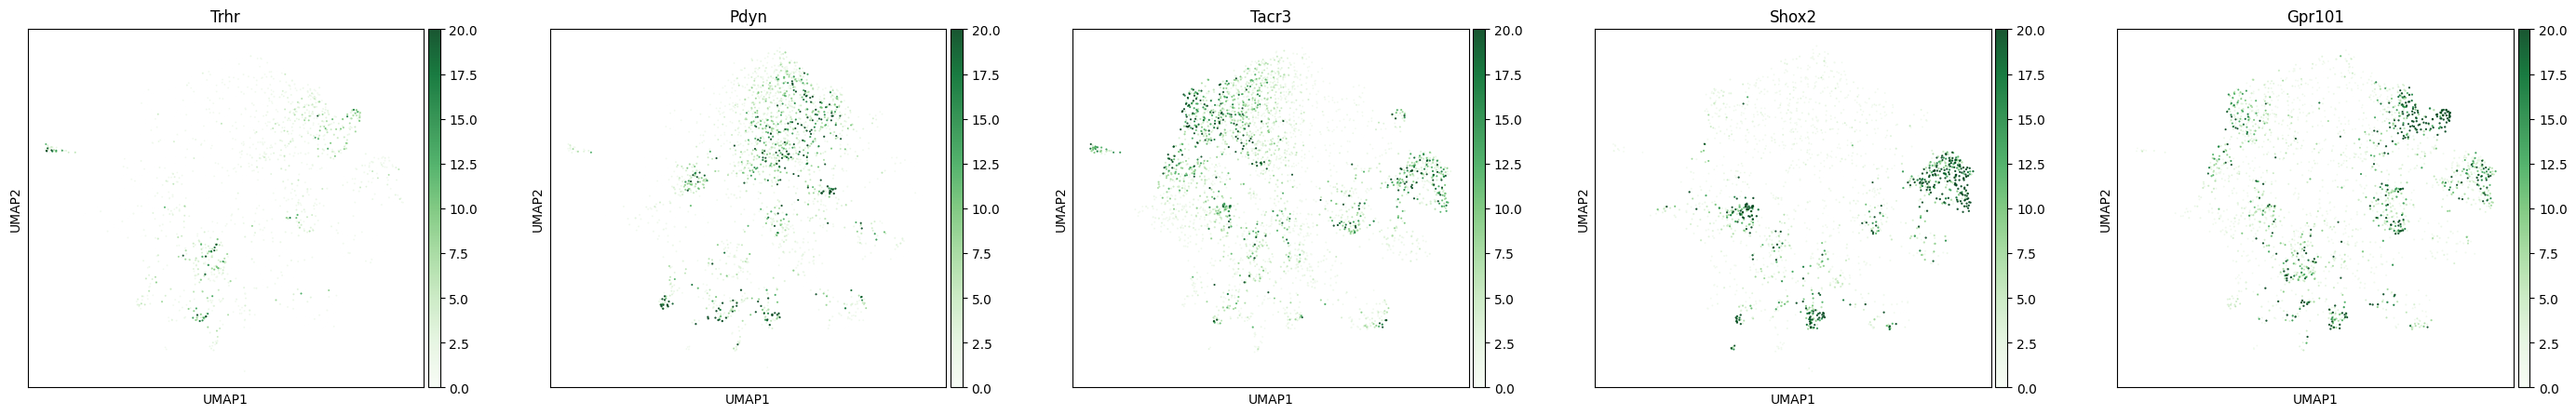

In [36]:
intersted_genes = ['Trhr','Pdyn','Tacr3','Shox2','Gpr101',]
fig, axes = plt.subplots(1,5,figsize=(35,5),)
for k in range(len(intersted_genes)):
    sc.pl.umap(adata_mer, ax = axes[k],color=intersted_genes[k], sort_order=True, 
               show=False,cmap ='Greens',vmax = 20,
               size =np.clip(adata_mer.X[:,np.where(adata_mer.var_names==intersted_genes[k])[0][0]],.01,None),
               alpha =.9)

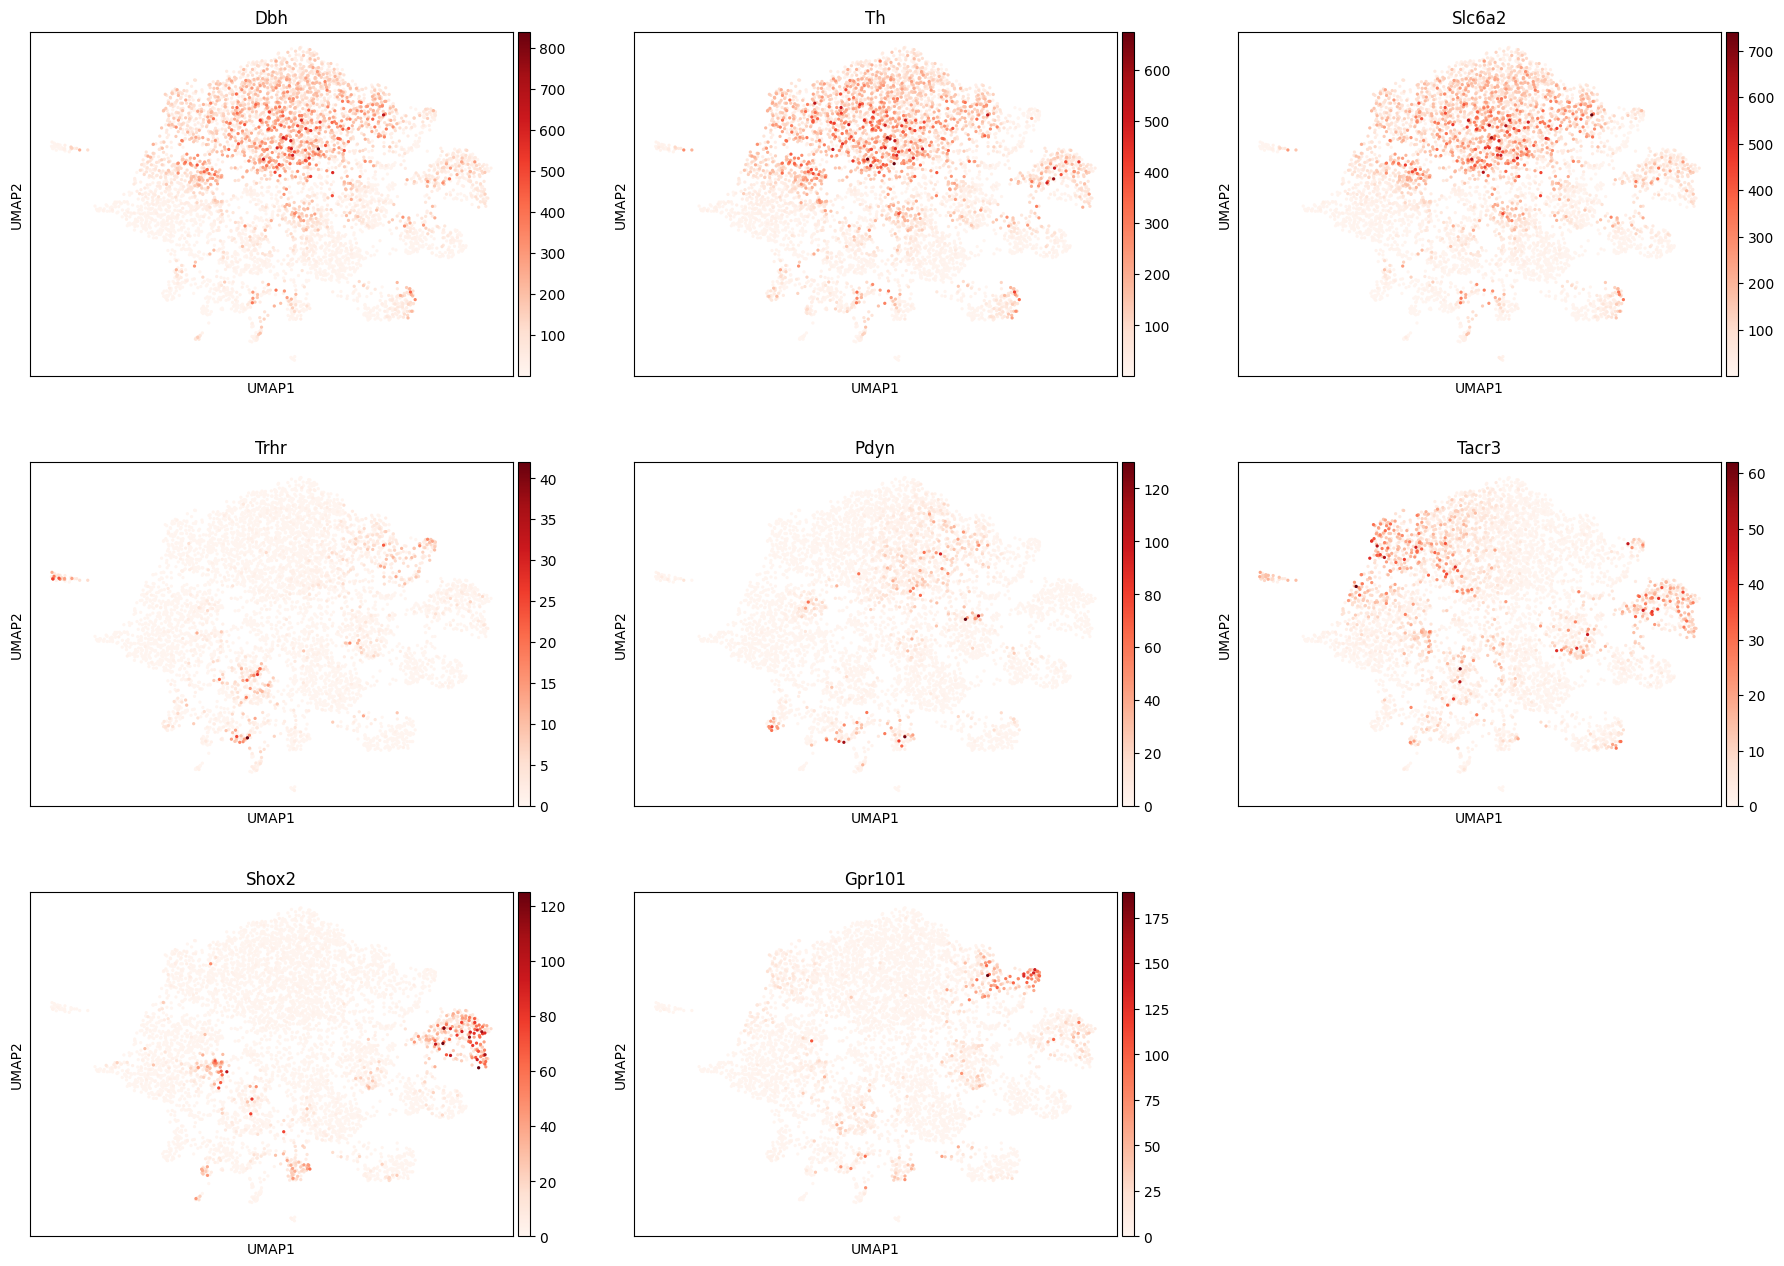

In [37]:
sc.pl.umap(adata_mer, color=['Dbh','Th',"Slc6a2"]+intersted_genes, 
           cmap = 'Reds', ncols=3)


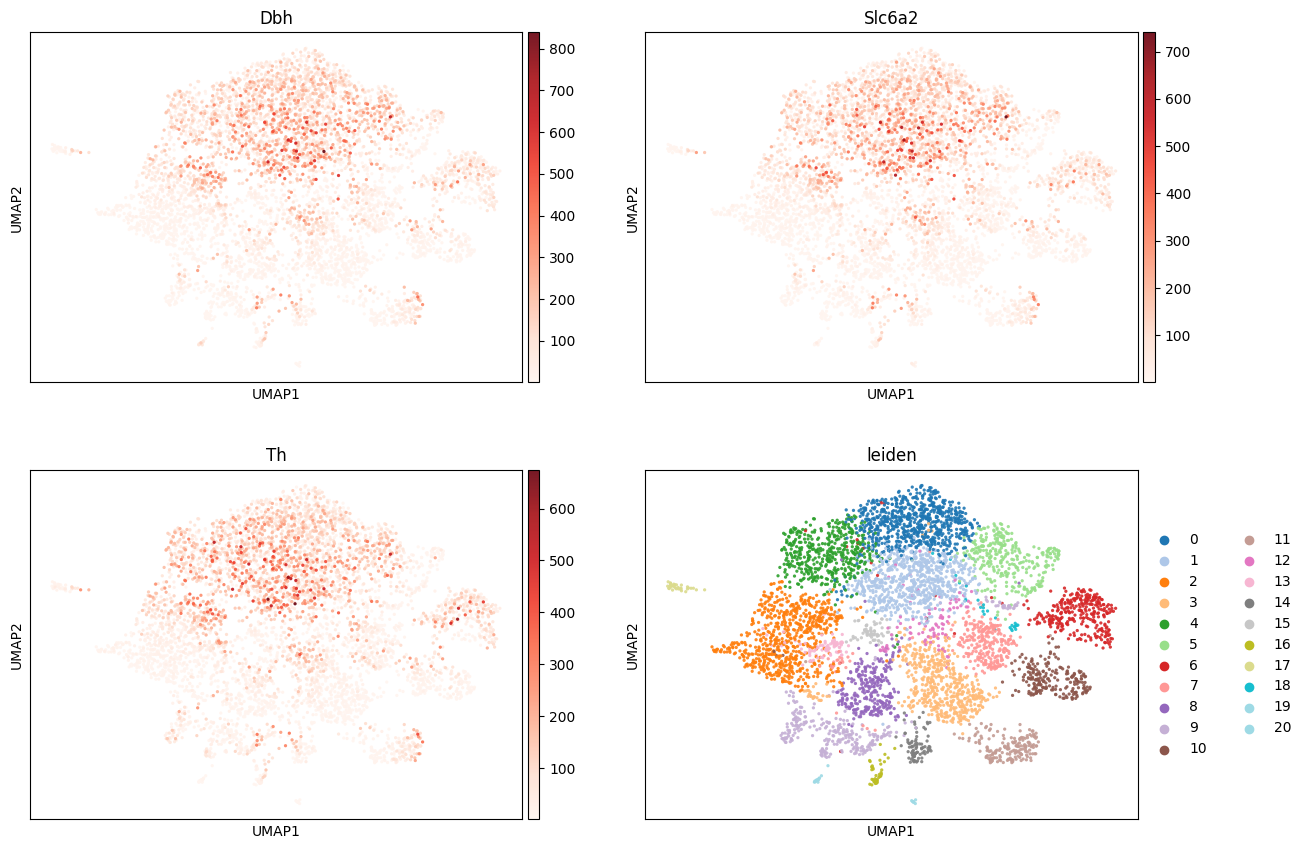

In [38]:
sc.pl.umap(adata_mer, color=['Dbh','Slc6a2','Th','leiden'],use_raw=True,
           cmap ='Reds',ncols=2,palette="tab20",
           alpha =.9) 

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

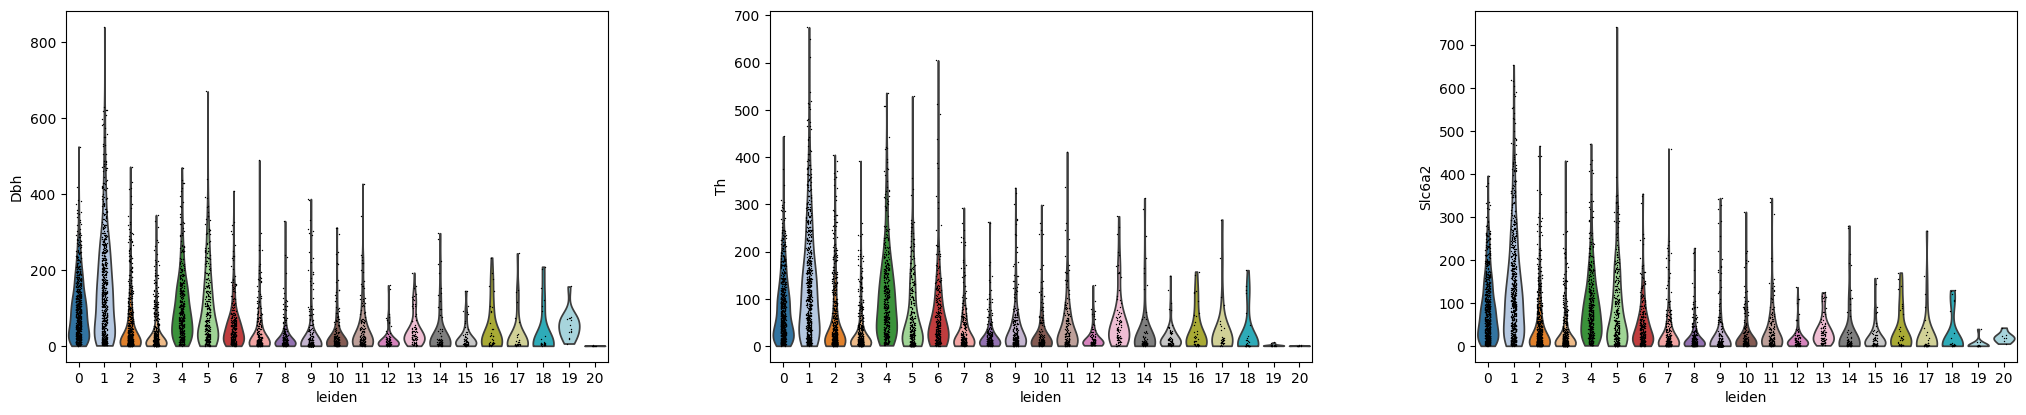

In [41]:
# Check expression of known markers
sc.pl.violin(adata_mer, ['Dbh','Th','Slc6a2'], groupby='leiden')

# choose your clusters here. 

In [79]:
chosen_ks = [0,1,2,4,5,7] # this is the clusters of interest based on leiden algorithm
# chosen_ks = [0,6,7,8,10,]

In [80]:
[str(k) for k in chosen_ks]

['0', '1', '2', '4', '5', '7']

In [81]:
mask = adata_mer.obs['leiden'].isin([str(k) for k in chosen_ks]) 
adata_subset = adata_mer[mask].copy() 
print(f"Original size: {adata_mer.n_obs} cells")
print(f"Subset size: {adata_subset.n_obs} cells")

Original size: 5473 cells
Subset size: 3227 cells


In [82]:
adata_subset = adata_mer[mask].copy() 
leidenmaskthingy = np.array(adata_subset.obs['leiden'].copy())

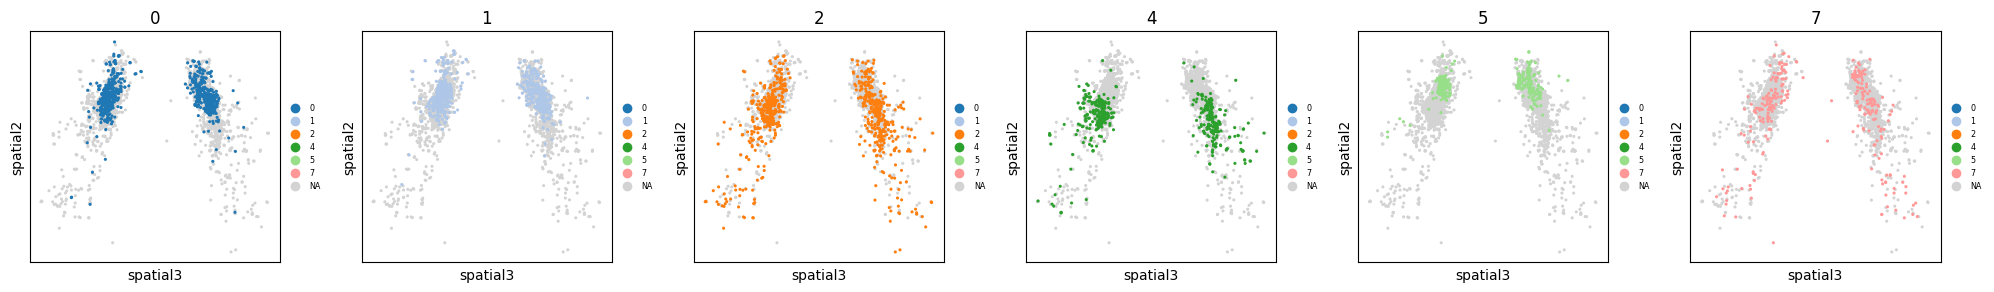

In [83]:
fig, axes = plt.subplots(1,len(chosen_ks),figsize=(25,3))

for i,k in enumerate(chosen_ks):
    
    adata_subset = adata_mer[mask].copy() 
    sc.pl.embedding(adata_subset,  mask_obs=(leidenmaskthingy==str(k)),color='leiden',ax = axes[i],
                     dimensions = (2, 1),basis="spatial", size = 20,alpha = 1,
                     title=str(k), show=False, legend_fontsize='xx-small',)
    axes[i].invert_yaxis()
    axes[i].set_aspect('equal')

fig.savefig('./coronal.png', dpi=200)

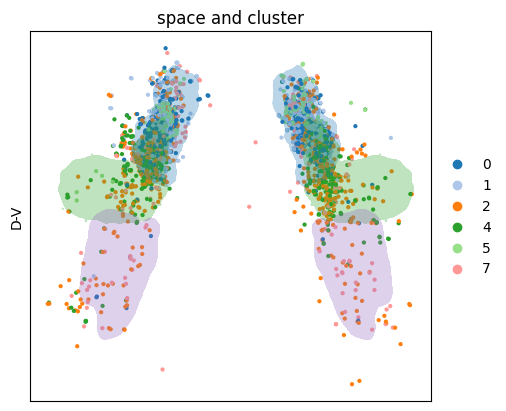

In [84]:
adata_subset = adata_mer[mask].copy() 
ax = sc.pl.embedding(adata_subset, 
                     dimensions = (2, 1),
                     basis="spatial", 
                     color="leiden",
#                      palette="tab20",
                     title='space and cluster', show=False,return_fig=True)
ax.gca().invert_yaxis()
ax.gca().set_aspect('equal')
ax.gca().triplot(mesh_LC.vertices.T[2], mesh_LC.vertices.T[1], mesh_LC.faces, alpha = .3, label = 'LC')
ax.gca().triplot(mesh_CD.vertices.T[2], mesh_CD.vertices.T[1], mesh_CD.faces, alpha = .3, label = 'CD')
ax.gca().triplot(mesh_CV.vertices.T[2], mesh_CV.vertices.T[1], mesh_CV.faces, alpha = .3, label = 'CV')
ax.gca().set_ylabel('D-V')
ax.gca().set_xlabel('')
ax.savefig('./spoace_cluster2.png', dpi=200)

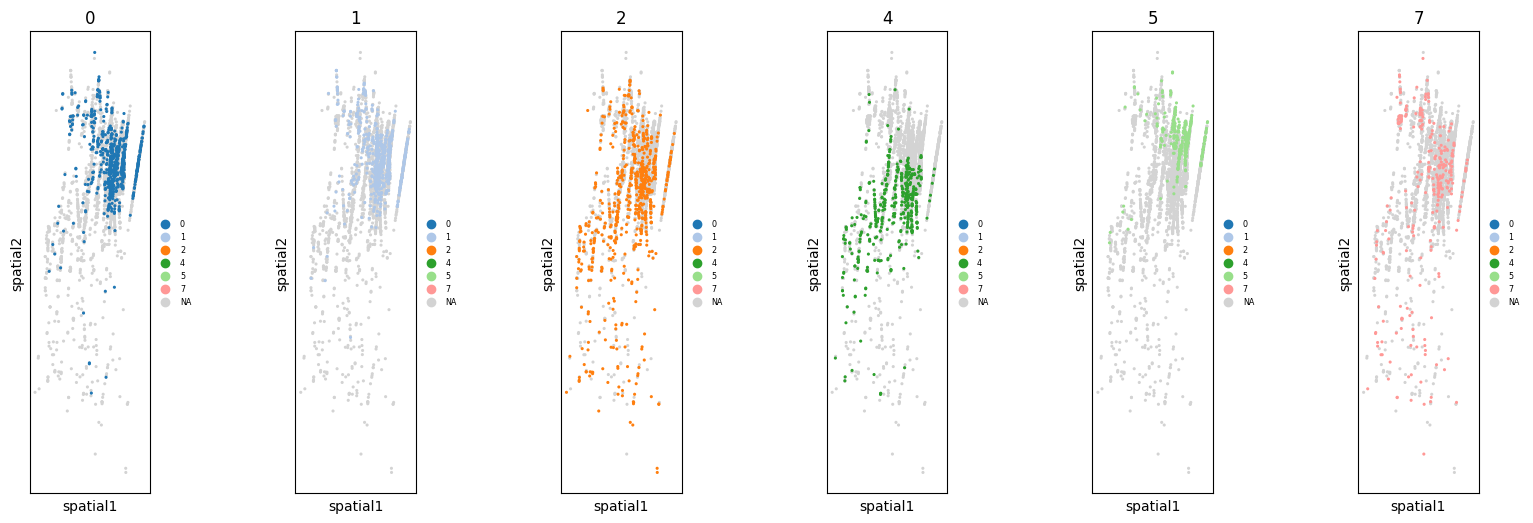

In [85]:
fig, axes = plt.subplots(1,len(chosen_ks),figsize=(20,6))

for i,k in enumerate(chosen_ks):
    
    adata_subset = adata_mer[mask].copy() 
    sc.pl.embedding(adata_subset,  mask_obs=(leidenmaskthingy==str(k)),color='leiden',ax = axes[i],
                     dimensions = (0, 1),basis="spatial", size = 20,alpha = 1,
                     title=str(k), show=False, legend_fontsize='xx-small',)
    axes[i].invert_yaxis()
    axes[i].set_aspect('equal')
# ax.invert_yaxis()
# ax.set_aspect('equal')
fig.savefig('./sagital.png', dpi=200)

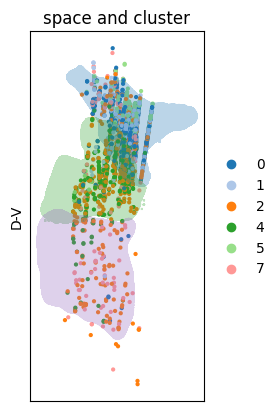

In [86]:
adata_subset = adata_mer[mask].copy() 
ax = sc.pl.embedding(adata_subset, 
                     dimensions = (0, 1),
                     basis="spatial", 
                     color="leiden",
#                      palette="tab20",
                     title='space and cluster', show=False,return_fig=True)
ax.gca().invert_yaxis()
ax.gca().set_aspect('equal')
ax.gca().triplot(mesh_LC.vertices.T[0], mesh_LC.vertices.T[1], mesh_LC.faces, alpha = .3, label = 'LC')
ax.gca().triplot(mesh_CD.vertices.T[0], mesh_CD.vertices.T[1], mesh_CD.faces, alpha = .3, label = 'CD')
ax.gca().triplot(mesh_CV.vertices.T[0], mesh_CV.vertices.T[1], mesh_CV.faces, alpha = .3, label = 'CV')
ax.gca().set_ylabel('D-V')
ax.gca().set_xlabel('')
ax.savefig('./spoace_cluster2_sagital.png', dpi=200)

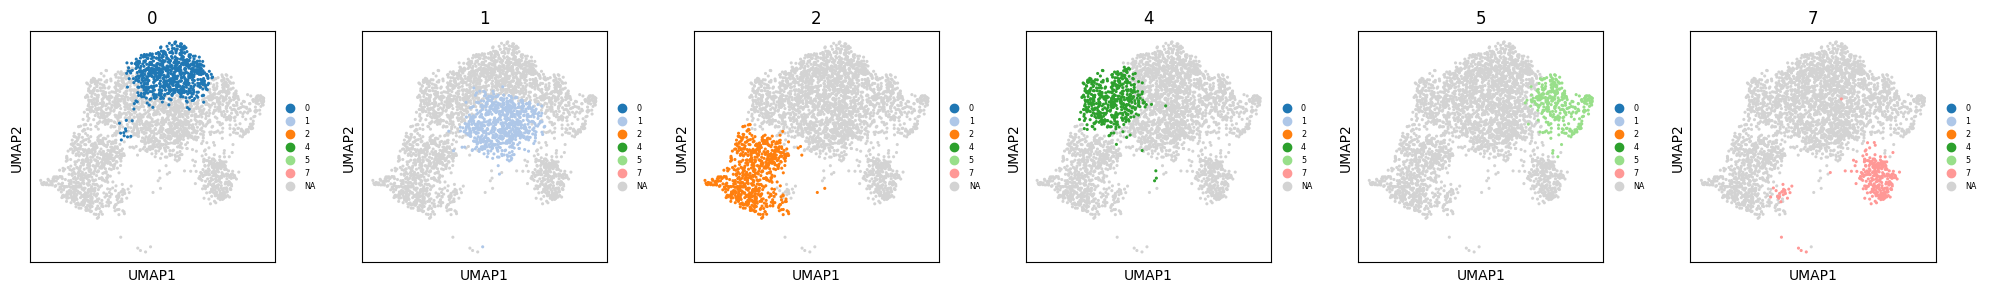

In [87]:
fig, axes = plt.subplots(1,len(chosen_ks),figsize=(25,3),)

for i,k in enumerate(chosen_ks):
    adata_subset = adata_mer[mask].copy() 
    sc.pl.umap(adata_subset,  mask_obs=(leidenmaskthingy==str(k)),color='leiden',
               ax = axes[i],size = 20,alpha = 1,title=str(k), show=False, legend_fontsize='xx-small')
#     axes[i].invert_yaxis()
    axes[i].set_aspect('equal')
        
fig.savefig('./umap.png', dpi=200) 

<Axes: title={'center': 'Dbh cell clusters'}, xlabel='UMAP1', ylabel='UMAP2'>

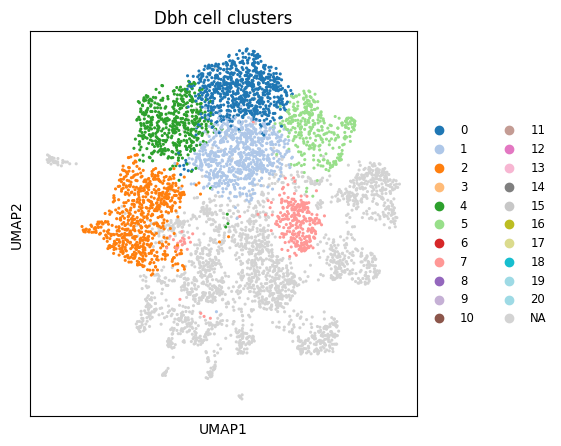

In [88]:
adata_subset = adata_mer[mask].copy() 
fig, axes = plt.subplots(1,1,figsize=(5,5),)

sc.pl.umap(adata_mer,  mask_obs=mask,  color='leiden',ax = axes,
          size = 20,alpha = 1,title='Dbh cell clusters', show=False, legend_fontsize='small')

        
# fig.savefig('./umap_allclusters.png', dpi=200) 

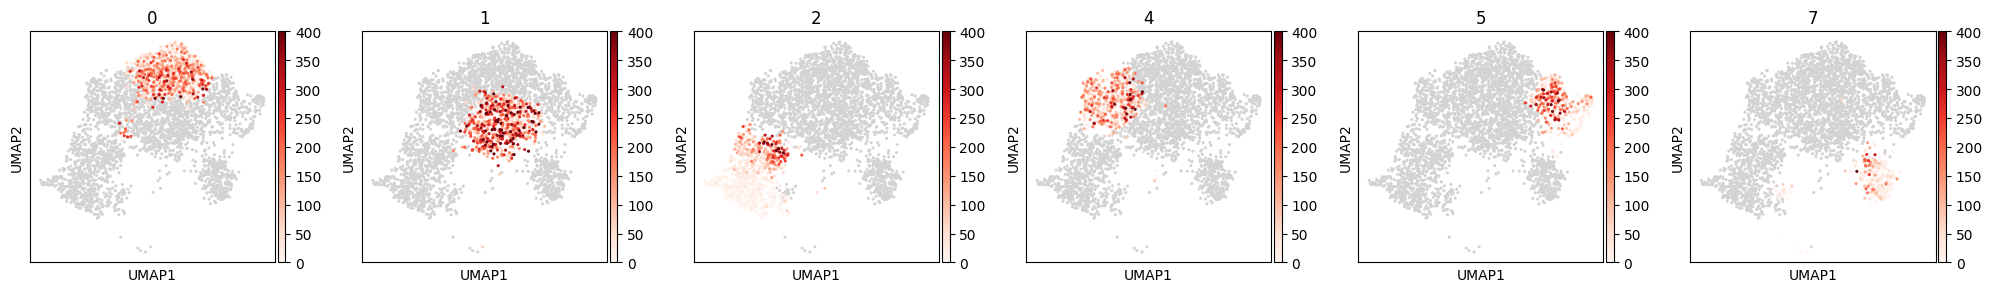

In [90]:
fig, axes = plt.subplots(1,len(chosen_ks),figsize=(25,3),)

for i,k in enumerate(chosen_ks):
    adata_subset = adata_mer[mask].copy() 
    sc.pl.umap(adata_subset, mask_obs=(leidenmaskthingy==str(k)), color='Dbh',cmap ='Reds',
               vmin = 0, vmax = 400,legend_fontsize='xx-small',
               ax = axes[i],size = 20,alpha = 1,title=str(k), show=False)
#     axes[i].invert_yaxis()
    axes[i].set_aspect('equal')
adata_subset = adata_mer[mask].copy()     
# fig.savefig('./DBH_express.png', dpi=200)    

# want to have a good visualization on gene gradients

In [91]:
adata_subset.shape

(3227, 315)

In [ ]:

ax = sc.pl.embedding(adata_subset, dimensions = (2, 1),basis="spatial", cmap ='Reds',
                     color=intersted_genes,ncols =3, show=False)

for a in ax:
    a.triplot(mesh_LC.vertices.T[2], mesh_LC.vertices.T[1], mesh_LC.faces, alpha = .1, label = 'LC')
    a.triplot(mesh_CD.vertices.T[2], mesh_CD.vertices.T[1], mesh_CD.faces, alpha = .1, label = 'CD')
    a.triplot(mesh_CV.vertices.T[2], mesh_CV.vertices.T[1], mesh_CV.faces, alpha = .1, label = 'CV')
    a.invert_yaxis()
    a.set_aspect('equal')
fig.tight_layout()

# save these as teh LC-NE populations for the future analysis? 

In [93]:
adata_subset.shape

(3227, 315)

In [94]:
markergenes

['Dbh', 'Th', 'Slc6a2']

In [95]:
markgene_expr = np.concatenate([adata_subset.X[:,adata_subset.var_names == k] for k in markergenes], axis = 1)
gradgene_expr = np.concatenate([adata_subset.X[:,adata_subset.var_names == k] for k in intersted_genes], axis = 1)

In [96]:
np.prod(markgene_expr, 1).min()

np.float64(325.3692009472618)

In [97]:
markgene_expr.shape

(3227, 3)

In [98]:
markgene_expr.shape, gradgene_expr.shape

((3227, 3), (3227, 5))

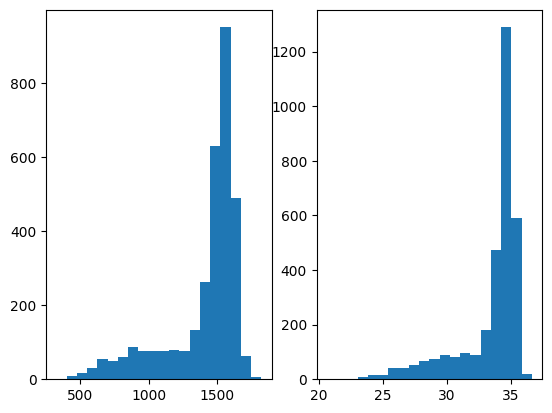

In [99]:
plt.subplot(1,2,1);plt.hist(np.prod(markgene_expr, 1), bins = 20);
plt.subplot(1,2,2);plt.hist(np.sum(markgene_expr, 1), bins = 20);

In [100]:
filename = '/allen/aind/scratch/shuonan.chen/code/pons_merfish_pipeline/processing/adata_mer_subset_3k.h5ad'
adata_subset.write(filename)
